In [29]:
import pandas as pd
import numpy as np 
from datetime import datetime

In [31]:
# Convert datetime format: '%m/%d/%Y' to '%Y-%m-%d'
def dt_reformat(date):
    dt = datetime.strptime(date, '%m/%d/%Y')
    return dt.strftime('%Y-%m-%d')

In [41]:
sp6m = pd.read_csv(r'C:\Users\azhe1\Desktop\IAQF\data\sp6m_6.csv')
sp500 = pd.read_csv('sp500_data.csv', index_col='Date')


idt = dt_reformat('1/12/2007')
index = np.where(sp500.index == idt)[0][0]
np.var(sp500['Close'][index-19:index+1])

36.638006569854916

In [ ]:
# Calculate the volatility of volatility
# idt: datetime in mpd_data
# data: historical price
# K: K day long rolling window 

def vol_of_vol(idt, data, K):
    
    var = []
    for d in idt:
        index = np.where(data.index == dt_reformat(d))[0][0]
        var

In [35]:
sp6m['idt']

0       1/12/2007
1       1/31/2007
2       2/15/2007
3       2/28/2007
4       3/15/2007
          ...    
680    12/13/2023
681    12/20/2023
682    12/27/2023
683      1/3/2024
684     1/10/2024
Name: idt, Length: 685, dtype: object

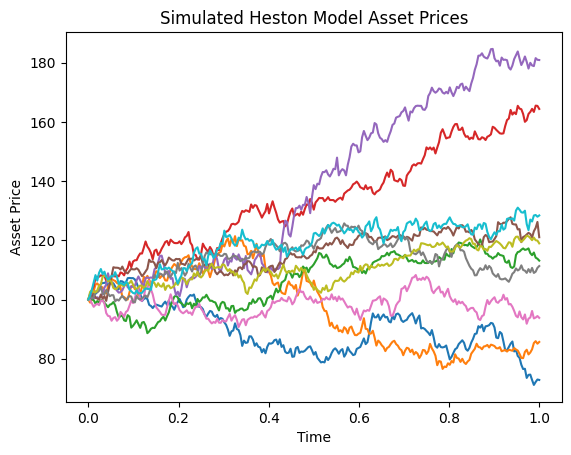

Overall Mean: 112.28304782906288
Overall Volatility: 0.18320213875714456


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql

def heston_model_simulation(params, spot_price, T, N, M):
    kappa, theta, sigma, rho, v0 = params

    # Time discretization
    dt = T / N
    dW1 = np.random.normal(size=(N, M)) * np.sqrt(dt)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(size=(N, M)) * np.sqrt(dt)

    # Initialize arrays for asset prices and volatilities
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))

    S[0, :] = spot_price
    v[0, :] = v0

    for i in range(1, N+1):
        # Euler discretization for asset prices
        S[i, :] = S[i-1, :] * np.exp(-0.5 * v[i-1, :] * dt + np.sqrt(v[i-1, :]) * dW1[i-1, :])

        # Euler discretization for volatilities
        v[i, :] = v[i-1, :] + kappa * (theta - v[i-1, :]) * dt + sigma * np.sqrt(v[i-1, :]) * dW2[i-1, :]

        # Ensure volatility stays non-negative
        v[i, :] = np.maximum(v[i, :], 0.0)

    return S, v

# Calculate mean and volatility from simulated prices
def calculate_estimates(S):
    # Calculate mean and volatility along each path
    mean_prices = np.mean(S, axis=1)
    volatility_prices = np.std(np.diff(np.log(S), axis=0), axis=1) / np.sqrt(dt)

    # Overall mean and volatility across all paths
    overall_mean = np.mean(mean_prices)
    overall_volatility = np.mean(volatility_prices)

    return overall_mean, overall_volatility

# Example parameters
params = [1.0, 0.04, 0.2, -0.5, 0.04]
spot_price = 100.0
T = 1.0
N = 252
M = 10

# Run the Heston model simulation
asset_prices, volatilities = heston_model_simulation(params, spot_price, T, N, M)

# Calculate mean and volatility from simulated prices
overall_mean, overall_volatility = calculate_estimates(asset_prices)

# Plot a few simulated paths
time = np.linspace(0, T, N+1)
for i in range(M):
    plt.plot(time, asset_prices[:, i])

plt.title('Simulated Heston Model Asset Prices')
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.show()

print(f"Overall Mean: {overall_mean}")
print(f"Overall Volatility: {overall_volatility}")


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import QuantLib as ql
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, Bounds

# feller condition function
def constr_f(x):
    return np.array(2*x[0]*x[1]-x[2]**2)


# used to get Heston Parameter
def setup_model(_yield_ts, _dividend_ts, _spot, init_condition=(0.02, 0.2, 0.5, 0, 0.01)):
    calendar = ql.China(ql.China.SSE)
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts,
                               ql.QuoteHandle(ql.SimpleQuote(_spot)),
                               v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    return model, engine

# input option info
def setup_helpers(engine, option_df, ref_date, spot, yield_ts, dividend_ts):
    calendar = ql.China(ql.China.SSE)
    heston_helpers = []
    grid_data = []
    for i in range(len(option_df)):
        t = (ql.DateParser.parseFormatted(option_df["maturity_date"][i], '%Y-%m-%d') - ref_date)
        spot = option_df["fut"][i]
        p = ql.Period(t, ql.Days)
        volatility = option_df["sigma"][i]
        helper = ql.HestonModelHelper(
            p, calendar, spot, option_df["K"][i] \
            , ql.QuoteHandle(ql.SimpleQuote(volatility)),
            yield_ts, dividend_ts)
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)
        grid_data.append((ql.DateParser.parseFormatted(option_df["maturity_date"][i], '%Y-%m-%d') \
                              , option_df["K"][i]))
    return heston_helpers, grid_data


def cost_function_generator(model, helpers, norm=True):
    def cost_function(params):
        params_ = ql.Array(list(params))
        model.setParams(params_)
        error = [h.calibrationError() for h in helpers]
        if norm:
            return np.sum(np.abs(error))
        else:
            return error

    return cost_function


def calibration_report(helpers, grid_data):
    avg = 0.0
    for i, opt in enumerate(helpers):
        err = (opt.modelValue() - opt.marketValue())
        date, strike = grid_data[i]
        avg += 0.5*err**2
    avg = avg * 100.0 / len(helpers)
    summary = "Square Error (%%) : %5.9f" % (avg)
    return avg


def get_Hestonpara(dataframe):
    day_count = ql.Actual365Fixed()
    calendar = ql.China(ql.China.SSE)
    aotmdata0 = dataframe
    # set Heston Condition
    calculation_date = ql.DateParser.parseFormatted(aotmdata0["current_date"][0], '%Y-%m-%d')
    spot = aotmdata0["S"][0]
    ql.Settings.instance().evaluationDate = calculation_date

    risk_free_rate = aotmdata0["r"].iloc[0]
    dividend_rate = 0.0

    # build term structure
    yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

    # get calibration result summary
    summary = []
    modelDE, engineDE = setup_model(yield_ts, dividend_ts, spot)
    heston_helpersDE, grid_dataDE = setup_helpers(engineDE, aotmdata0, calculation_date, spot, yield_ts, dividend_ts)
    initial_condition = list(modelDE.params())

    # set heston parameter bounds
    bounds = [(0.001, 1.0), (0.1, 25.0), (0.01, 4), (-1.0, 1.0), (0.001, 1.0)]
    cost_function = cost_function_generator(modelDE, heston_helpersDE, norm=True)
    nlc = NonlinearConstraint(constr_f, 0, np.inf)
    # use diffirential_evolution
    sol = differential_evolution(cost_function, bounds, constraints=(nlc), maxiter=5000, seed=1)
    theta, kappa, sigma, rho, v0 = modelDE.params()
    error = calibration_report(heston_helpersDE, grid_dataDE)
    summary.append([aotmdata0["current_date"][0], error, risk_free_rate, spot] + list(modelDE.params()))
    result_df = pd.DataFrame(summary,
                             columns=['current_date', 'Error', 'Risk_free_rate', 'Spot', 'Theta', 'Kappa', 'Sigma',
                                      'Rho', 'V0'])
    return result_df

In [69]:
asset_prices

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [101.96456401,  98.96103275, 100.20885296, ..., 101.0806824 ,
        102.56069286, 101.3592232 ],
       [100.0923614 ,  99.94043765, 100.05355252, ..., 100.29009207,
        103.21680465, 103.29659573],
       ...,
       [ 72.13828369,  85.92516802, 114.14684727, ..., 109.39448396,
        120.03199779, 128.56376929],
       [ 72.96274477,  85.06375532, 113.78214407, ..., 110.67988675,
        119.90875044, 127.979861  ],
       [ 72.81634617,  85.65330253, 113.13953816, ..., 111.30416201,
        118.97203067, 128.412578  ]])